Cython
====

Cython is an "optimizing static compiler " that combines Python with C to generate optimized code. Since Cython is a superset of Python, all valid Python programs are also valid Cython programs. However, by providing hints and static typing, we can get much faster programs. Note that while `numba` often provides similar speedups with less work,, an advantage of Cython is that it is easy to distribute optimized Cython modules since they can be built with the standard Python `setup.py` script.

We have already seen how to use Cython to wrap C and C++ functions from existing libraries. Here we will see how to use Cython to speed up Python functions. 

### Resources

- [Cython documentation](http://docs.cython.org/index.html)
- [Cython: A guide for Python programmers](http://www.amazon.com/Cython-Kurt-W-Smith/dp/1491901551)

**Utility function for timing functions**

In [1]:
import time

In [2]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [3]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

Incremental improvements
----

Generally, we start with a pure Python function, run it through Cython with the annotate `-a` flag, and incrementally modify the code until the yellow parts are minimized.

How to build Cython modules
----

From [official docs](http://docs.cython.org/index.html)

Using Cython consists of these steps:

- Write a .pyx source file
- Run the Cython compiler to generate a C file
- Run a C compiler to generate a compiled library
- Run the Python interpreter and ask it to import the module

In the Jupyter notebook, we can use the `%%cython` cell magic to automate these steps.

In [8]:
%load_ext cython

#### Matrix multiplication example

In [25]:
def matrix_multiply(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [26]:
u = np.random.random((10,20))
v = np.random.random((20,5))

In [27]:
res = np.zeros((u.shape[0], v.shape[1]))
matrix_multiply(u, v, res)

array([[ 6.23206064,  5.02617378,  5.24195758,  2.99169761,  3.9401661 ],
       [ 5.44535991,  4.27051957,  5.09974356,  3.19339314,  4.4845852 ],
       [ 6.52695763,  4.9649044 ,  5.66479652,  3.73440473,  5.18981681],
       [ 5.47233217,  4.18485264,  4.34374265,  3.13801525,  4.27412098],
       [ 6.35742705,  5.02912642,  5.92758324,  3.56743263,  4.73902924],
       [ 5.57344818,  4.22251167,  4.12379554,  2.30636947,  4.08916241],
       [ 3.61588766,  2.28101131,  3.1266391 ,  2.32380826,  3.02340269],
       [ 4.96325909,  3.24325894,  4.12918062,  2.34622065,  3.23494718],
       [ 5.561466  ,  4.25910586,  4.87880398,  3.26787812,  4.11423797],
       [ 4.88445295,  4.11701615,  4.73502154,  3.06760703,  4.06496649]])

In [28]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply(u, v, res)

3 loops, best of 3: 1.02 ms per loop


### Using Cython annnotations to identify bottlenecks

In [29]:
%%cython -a

import numpy as np

def matrix_multiply1(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

### Using Cython cdefs and directives

In [30]:
%%cython -a

import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply1(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil:
        for i in range(m):
            for j in range(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [31]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply1(u, v, res)

3 loops, best of 3: 13.4 µs per loop


### Parallel execution with Cython

Will not work unless OpenMP is installed.

In [32]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply2(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil, parallel():
        for i in prange(m):
            for j in prange(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [33]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply2(u, v, res)

The slowest run took 12.73 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 12.7 µs per loop


In [4]:
import time

In [5]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color   

Mandelbrot created on CPU in 30.301049 s


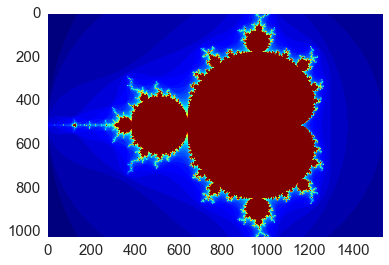

In [6]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

In [37]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

# color function for point at (x, y)
cdef unsigned char mandel_cython(double x, double y, int max_iters):
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(double xmin, double xmax, double ymin, double ymax, unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created on CPU in 0.276794 s


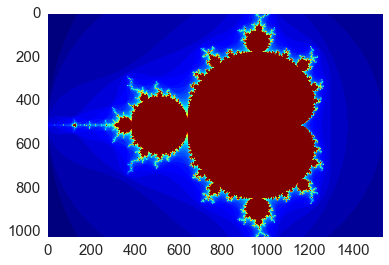

In [39]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass